In [86]:
!pip install pytorch_metric_learning;

In [87]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm.auto import tqdm
import albumentations as A

from sklearn.model_selection import train_test_split


In [88]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="TR2n5JTcwaRKLAU3sNDd")
project = rf.workspace("mike-caulfild").project("eyeofthetiger")
dataset = project.version(1).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to EyeOfTheTiger-1 in multiclass:: 100%|██████████| 1839/1839 [00:00<00:00, 2097.30it/s]


In [71]:
import random

test_list = ["0", "1"]
random_index = random.randint(0, len(test_list) - 1)
random_index

1

In [89]:
import os, os.path
os.remove ("/kaggle/working/EyeOfTheTiger-1/train/_classes.csv")
DIR = '/kaggle/working/EyeOfTheTiger-1/train'
names =  ([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
lennames = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
lennames

1465

In [90]:
mamesdf = pd.read_csv('/kaggle/input/clasees-for-tiger/classes_upd3.csv')
mamesdf

,filename,number_of_class
0,2939_jpg.rf.00cf6b478f418f40aea2bfe34c76489f.jpg,2
1,0324_jpg.rf.03c9dd43d36afb591ff88e708ced5ddf.jpg,2
2,1680_jpg.rf.0274f718df5200f76476d0d7e9f929ff.jpg,7
3,0587_jpg.rf.00bd743d4a3bf6cabb5db0aca09c5efd.jpg,10
4,0365_jpg.rf.004bfa61c800c550f15f7358d11d4353.jpg,5
...,...,...
1460,1661_jpg.rf.b05fbd75f64fde25dbfd6f88f6d17f26.jpg,5
1461,0812_jpg.rf.b09e27344ac228b804c11d8963fead8a.jpg,9
1462,1324_jpg.rf.ab22b130da886663bc652e4f1462c89e.jpg,3
1463,0025_jpg.rf.b0fb07f2bf355648e22faf91e5d8a186.jpg,2


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pytorch_metric_learning import losses

In [92]:
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification

In [93]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [94]:
train = mamesdf

In [ ]:
train

In [95]:
train.rename(columns = {'filename':'img_path', 'number_of_class':'label'}, inplace = True )

In [ ]:
train

In [96]:
label2idx = {0:'unlabled', 1:'back', 2:'front', 3:'left', 4:'left_with_incomplete_pattern', 5: 'left_with_unreadable_pattern', 6:'other', 7:'right',8:'right_with_incomplete_pattern',9:'right_with_unreadable_pattern',10:'top'}
model = 'google/vit-base-patch16-384'
root_dir = '/kaggle/working/EyeOfTheTiger-1/train'
batch_size = 8
num_labels = 11
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [97]:
train, val, _, _ = train_test_split(train, train['label'], test_size=0.1)

In [98]:
class LandmarkDataset(Dataset):

    def __init__(self, meta, root_dir, transform=None):
        self.meta = meta
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = self.meta['img_path'].iloc[idx]
        img_name = os.path.join(
            self.root_dir,
            image_id
        )
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image=np.asarray(image))['image']
            image = Image.fromarray(image)

        image = feature_extractor(images=image, return_tensors="pt")
            
        cls = self.meta['label'].iloc[idx]

        return image, cls

In [99]:
train_transform = A.Compose([
        A.HorizontalFlip(),
        A.GaussNoise(p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.2, rotate_limit=30, p=0.75),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

transform = None

In [83]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model)
feature_extractor.save_pretrained('feature_extractor')

In [100]:
train_dataset = LandmarkDataset(meta=train, root_dir=root_dir, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = LandmarkDataset(meta=val, root_dir=root_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [101]:
model = ViTModel.from_pretrained(model)
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )

In [102]:
EPOCHS = 4
lr = 0.00001

# Зададим оптимизатор
optimizer = optim.AdamW(model.parameters(), lr) # ЗДЕСЬ ВАШ КОД

criterion = losses.ArcFaceLoss(num_labels, 768).to(device)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-9)

In [103]:
for epoch in range(EPOCHS):
    
    model.train()     
        
    train_loss = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        for i in batch:
            batch[i] = batch[i][:, 0].to(device)
        targets = targets.to(device)
        predictions = model(**batch).pooler_output
        
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    print('Training loss:', np.mean(train_loss))
    val_loss = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            for i in batch:
                batch[i] = batch[i][:, 0].to(device)
            targets = targets.to(device)
            predictions = model(**batch).pooler_output

            loss = criterion(predictions, targets) 
            
            val_loss.append(loss.item())
        
    print('Val loss:', np.mean(val_loss))
    model.save_pretrained('model')


Epoch: 0:   0%|          | 0/165 [00:00<?, ?it/s]

Training loss: 32.31903157089696


Epoch: 0:   0%|          | 0/19 [00:00<?, ?it/s]

Val loss: 30.854719563534385


Epoch: 1:   0%|          | 0/165 [00:00<?, ?it/s]

Training loss: 29.425314284815933


Epoch: 1:   0%|          | 0/19 [00:00<?, ?it/s]

Val loss: 26.73597626937063


Epoch: 2:   0%|          | 0/165 [00:00<?, ?it/s]

Training loss: 26.294653372331098


Epoch: 2:   0%|          | 0/19 [00:00<?, ?it/s]

Val loss: 25.138472506874486


Epoch: 3:   0%|          | 0/165 [00:00<?, ?it/s]

Training loss: 23.73614585760868


Epoch: 3:   0%|          | 0/19 [00:00<?, ?it/s]

Val loss: 22.03337167438708


In [104]:
test = pd.read_csv('/kaggle/input/clasees-for-tiger/classes_valid_upd.csv')
test.rename(columns = {'filename':'img_path', 'number_of_class':'label'}, inplace = True )

In [105]:
test_dataset = LandmarkDataset(meta=test, root_dir='/kaggle/working/EyeOfTheTiger-1/valid', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4) 

In [107]:
model = ViTForImageClassification.from_pretrained('/kaggle/working/model')
model.to(device)

Some weights of the model checkpoint at /kaggle/working/model were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at /kaggle/working/model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [142]:
test

,img_path,label
0,0163_jpg.rf.d4f3a668ec8e86767afdb70c5b025ac4.jpg,3
1,2962_jpg.rf.c8e86044e8b393047b7ec4ebf30a03ff.jpg,7
2,1967_jpg.rf.d2e22c276d01aaca78b609d47140f075.jpg,3
3,1139_jpg.rf.d5943efbc2af2fccc1055dc5a23eaba5.jpg,2
4,0468_jpg.rf.cbc6a54031672be77ac9af46d8222c8f.jpg,8
...,...,...
363,3813_jpg.rf.18e587b10056713a8d688059f9ae7294.jpg,2
364,4398_jpg.rf.1804334b9f8072181b3a5157684a6f10.jpg,7
365,3633_jpg.rf.192e150e18c0a801fabcb8bdd22d01af.jpg,7
366,0026_jpg.rf.1962a21c05f2cdf7b0dbe696bea4e506.jpg,7


In [147]:
num = test.img_path[3]

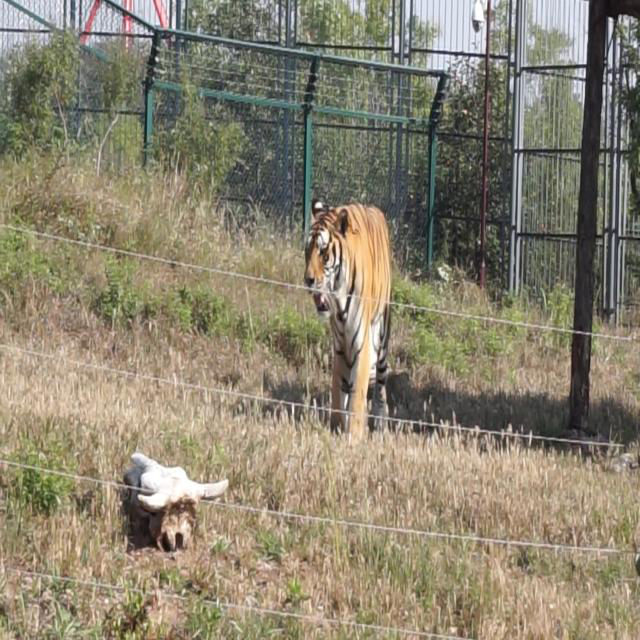

In [148]:
aa = Image.open(f'/kaggle/working/EyeOfTheTiger-1/valid/{num}')
aa

In [134]:
train_dataset[2]

({'pixel_values': tensor([[[[0.9294, 0.9216, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
           [0.9686, 0.9294, 0.8980,  ..., 1.0000, 1.0000, 1.0000],
           [0.9608, 0.9294, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.7412, 0.6863, 0.6784,  ..., 0.7882, 0.8902, 0.8824],
           [0.7333, 0.7176, 0.7020,  ..., 0.6157, 0.7255, 0.8275],
           [0.7176, 0.7569, 0.7098,  ..., 0.5922, 0.6941, 0.8275]],
 
          [[0.5373, 0.5294, 0.5373,  ..., 1.0000, 1.0000, 1.0000],
           [0.5686, 0.5373, 0.5216,  ..., 1.0000, 1.0000, 1.0000],
           [0.5608, 0.5294, 0.5373,  ..., 0.9922, 1.0000, 1.0000],
           ...,
           [0.7961, 0.7255, 0.7098,  ..., 0.8118, 0.8980, 0.8745],
           [0.7882, 0.7569, 0.7176,  ..., 0.6627, 0.7490, 0.8431],
           [0.7647, 0.7882, 0.7255,  ..., 0.6471, 0.7255, 0.8431]],
 
          [[0.4196, 0.4275, 0.4431,  ..., 0.9765, 1.0000, 1.0000],
           [0.4745, 0.4431, 0.4275,  ..., 0.9529, 1.0000, 1.0000],
       

In [160]:
test.label[5]

2

In [ ]:
label2idx = {0:'unlabled', 1:'back', 2:'front', 3:'left', 4:'left_with_incomplete_pattern', 5: 'left_with_unreadable_pattern', 6:'other', 7:'right',8:'right_with_incomplete_pattern',9:'right_with_unreadable_pattern',10:'top'}

In [161]:

preds=[]
for image in test.img_path:
    images = Image.open(f'/kaggle/working/EyeOfTheTiger-1/valid/{image}')
    inputs = feature_extractor(images = images, return_tensors="pt")
    inputs = inputs.to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_idx = logits.argmax(-1).item()
    preds.append(train_dataset[predicted_idx][1])


In [162]:
preds

[2,
 5,
 2,
 2,
 3,
 3,
 3,
 4,
 7,
 3,
 3,
 0,
 2,
 2,
 2,
 5,
 3,
 7,
 3,
 2,
 7,
 2,
 2,
 2,
 2,
 3,
 2,
 0,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 5,
 2,
 2,
 2,
 2,
 7,
 2,
 9,
 4,
 2,
 3,
 2,
 2,
 9,
 3,
 0,
 7,
 8,
 2,
 2,
 0,
 0,
 3,
 3,
 2,
 7,
 9,
 2,
 9,
 2,
 0,
 2,
 9,
 2,
 2,
 7,
 2,
 3,
 2,
 0,
 2,
 6,
 4,
 8,
 8,
 2,
 7,
 2,
 2,
 5,
 0,
 4,
 8,
 9,
 6,
 2,
 2,
 4,
 2,
 2,
 6,
 3,
 0,
 5,
 2,
 2,
 9,
 3,
 2,
 9,
 2,
 2,
 9,
 2,
 0,
 8,
 3,
 3,
 2,
 7,
 4,
 3,
 9,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 7,
 2,
 2,
 8,
 9,
 7,
 2,
 2,
 2,
 9,
 3,
 2,
 0,
 7,
 8,
 2,
 2,
 2,
 2,
 8,
 7,
 4,
 4,
 7,
 2,
 3,
 2,
 2,
 2,
 2,
 4,
 3,
 0,
 2,
 1,
 2,
 3,
 0,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 6,
 2,
 2,
 7,
 9,
 2,
 0,
 4,
 2,
 0,
 1,
 2,
 0,
 3,
 3,
 7,
 2,
 2,
 5,
 2,
 3,
 0,
 7,
 2,
 2,
 3,
 2,
 7,
 2,
 2,
 0,
 9,
 2,
 7,
 7,
 4,
 4,
 7,
 2,
 7,
 3,
 3,
 2,
 7,
 8,
 2,
 8,
 2,
 2,
 9,
 7,
 2,
 8,
 2,
 0,
 3,
 9,
 0,
 3,
 9,
 2,
 2,
 3,
 7,
 4,
 7,
 2,
 2,
 4,
 2,
 3,
 2,
 3,


In [52]:
predicted_labels = predictions[1].argmax(0)

In [53]:
predicted_labels

tensor(187, device='cuda:0')

In [167]:
y_true = test.label.to_list()
y_true

[3,
 7,
 3,
 2,
 8,
 2,
 2,
 7,
 2,
 8,
 3,
 3,
 3,
 7,
 5,
 2,
 3,
 0,
 2,
 10,
 9,
 7,
 7,
 0,
 3,
 3,
 7,
 3,
 2,
 5,
 0,
 10,
 4,
 6,
 9,
 7,
 5,
 5,
 2,
 6,
 4,
 3,
 5,
 2,
 3,
 7,
 2,
 3,
 3,
 3,
 3,
 2,
 8,
 3,
 0,
 4,
 2,
 2,
 2,
 3,
 2,
 9,
 5,
 3,
 9,
 3,
 0,
 0,
 9,
 2,
 2,
 9,
 5,
 0,
 3,
 7,
 4,
 9,
 8,
 6,
 7,
 3,
 2,
 2,
 3,
 7,
 5,
 8,
 5,
 0,
 3,
 3,
 6,
 5,
 9,
 0,
 7,
 3,
 2,
 3,
 9,
 9,
 6,
 9,
 4,
 2,
 9,
 2,
 2,
 3,
 9,
 2,
 7,
 2,
 2,
 6,
 5,
 2,
 2,
 3,
 3,
 5,
 6,
 3,
 8,
 7,
 9,
 9,
 5,
 3,
 9,
 2,
 7,
 4,
 2,
 10,
 0,
 0,
 3,
 4,
 0,
 3,
 7,
 7,
 3,
 2,
 7,
 2,
 7,
 3,
 9,
 3,
 2,
 10,
 3,
 0,
 7,
 3,
 0,
 7,
 3,
 10,
 7,
 7,
 2,
 10,
 7,
 3,
 8,
 8,
 7,
 7,
 3,
 6,
 7,
 7,
 3,
 3,
 2,
 7,
 5,
 7,
 0,
 10,
 3,
 3,
 2,
 0,
 4,
 8,
 3,
 2,
 3,
 0,
 0,
 7,
 2,
 3,
 2,
 3,
 0,
 2,
 5,
 0,
 6,
 4,
 7,
 7,
 7,
 3,
 4,
 4,
 3,
 8,
 8,
 3,
 2,
 3,
 3,
 3,
 2,
 7,
 6,
 7,
 2,
 10,
 7,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 5,
 1,
 3,
 3,
 7,
 3,
 7,
 2,
 0,
 7,
 8,
 0,
 8,
 2,


In [171]:
confusion_matrix(y_true, y_pred)

array([[ 1,  1, 23,  0,  2,  0,  0,  2,  2,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 9,  0, 31, 19,  3,  2,  0,  9,  2,  1,  0],
       [ 8,  0, 31, 15,  5,  0,  3,  9,  2, 18,  0],
       [ 1,  0,  8,  5,  0,  0,  0,  2,  0,  1,  0],
       [ 2,  0,  9,  4,  1,  3,  0,  7,  0,  0,  0],
       [ 1,  0,  9,  1,  1,  0,  0,  4,  0,  0,  0],
       [ 2,  2, 32,  1,  3,  6,  1,  3,  7,  4,  0],
       [ 3,  0,  6,  4,  1,  0,  1,  1,  1,  0,  0],
       [ 0,  0, 13,  0,  2,  1,  0,  2,  0,  2,  0],
       [ 3,  0,  7,  1,  0,  0,  0,  0,  0,  0,  0]])

In [169]:
y_true = test.label.to_list()
y_pred = preds
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.03      0.03        32
           1       0.00      0.00      0.00         1
           2       0.18      0.41      0.25        76
           3       0.29      0.16      0.21        91
           4       0.00      0.00      0.00        17
           5       0.25      0.12      0.16        26
           6       0.00      0.00      0.00        16
           7       0.08      0.05      0.06        61
           8       0.07      0.06      0.06        17
           9       0.07      0.10      0.09        20
          10       0.00      0.00      0.00        11

    accuracy                           0.15       368
   macro avg       0.09      0.08      0.08       368
weighted avg       0.15      0.15      0.14       368



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
